# Random Forest para detección de toxicidad (IsToxic)

En este notebook entrenamos un modelo **Random Forest** sobre el dataset limpio
`youtoxic_english_1000_clean.csv`.

Seguimos el estándar del proyecto:

- Texto preprocesado (`text_classic`)
- 5 features numéricas del dataset limpio:
  - `text_len_classic`
  - `word_count_classic`
  - `uppercase_ratio`
  - `exclamation_count`
  - `hate_words_count`

Flujo del notebook:

1. Carga de datos y configuración.
2. Pipeline baseline completo con TF-IDF + features numéricas.
3. Evaluación **train y test** + control de overfitting (rubrica ≤ 5%).
4. Ajuste de hiperparámetros:
   - **Tuning** con:
     - `GridSearchCV`
     - `Optuna` 
5. Comparación final de versiones.
6. Selección del mejor modelo y guardado:
   - Pipeline completo en `.pkl` → `backend/models/<model_name>.pkl`
   - Métricas en `.json` → `data/results/<model_name>.json`

El objetivo es que este JSON sea compatible con `comparison_models.ipynb`, siguiendo el formato acordado para la comparación global del equipo.

Para todo ello, exponemos una explicación del flujo de trabajo realizado en este notebook:

### 🧭 Resumen del ajuste de hiperparámetros en Random Forest  
*(Baseline → GridSearchCV → Optuna → ajuste conservador)*

En este notebook hemos seguido un camino progresivo para **optimizar Random Forest** sobre un dataset pequeño (≈ 1.000 comentarios) y con **alta dimensionalidad** en texto (TF-IDF). Esto es importante porque:

- Los Random Forest pueden **memorizar fácilmente** cuando:
  - hay muchas features de texto,
  - y el dataset es pequeño.
- Por eso es habitual ver métricas de **train muy altas** (incluso 1.00) y una caída clara en test.

---

#### 1) ✅ Baseline
Primero entrenamos un Random Forest baseline para tener un punto de referencia.

**Qué observamos**
- El modelo aprende patrones rápidamente.
- Pero mostró un **gap alto entre train y test**.

**Interpretación**
- Patrón típico de **overfitting**:
  se adapta demasiado a los datos de entrenamiento.

---

#### 2) 🔍 GridSearchCV
Después probamos una búsqueda exhaustiva de hiperparámetros.

**Objetivo**
- Encontrar combinaciones que mejoren F1-score.

**Qué ocurrió**
- Aun con mejores hiperparámetros, el **gap siguió siendo elevado**.

**Lección**
- GridSearch optimiza rendimiento,
  pero no garantiza por sí solo **generalización** en datasets pequeños con texto denso.

---

#### 3) 🎯 Optuna
Luego pasamos a Optuna para explorar el espacio de parámetros de forma más flexible.

**Objetivo**
- Encontrar zonas prometedoras de hiperparámetros sin probar un grid fijo enorme.

**Qué ocurrió**
- Redujo el gap respecto a configuraciones muy libres,
  pero **no alcanzó el requisito de la rúbrica**.

**Lección**
- Cuando el problema es estructural (dataset pequeño + TF-IDF grande),
  se necesita **regularización más fuerte**.

---

#### 4) 🧯 Cambio de estrategia: ajuste conservador
Aquí aplicamos una estrategia distinta:

**En lugar de maximizar solo F1**, imponemos restricciones fuertes para cumplir:

> ✅ **Criterio de rúbrica:**  
> **F1_train - F1_test ≤ 0.05**

**Qué hacemos**
- Limitamos profundidad.
- Aumentamos `min_samples_leaf` y `min_samples_split`.
- Restringimos `max_features`.
- Reducimos también el `max_features` del TF-IDF.

**Resultado esperado**
- Mejor generalización.
- Menor riesgo de memorizar entrenamiento.

---

#### 5) 🧪 Barrido corto conservador
Para no depender de una única configuración manual,
probamos varias variantes ya “endurizadas”.

**Objetivo**
- Confirmar qué configuraciones cumplen el gap
  y cuál ofrece el mejor equilibrio final.

---

### ✅ Conclusión de esta fase
Con datasets pequeños y texto vectorizado con muchas dimensiones,
es preferible priorizar:

- **generalización (gap bajo)**  
- frente a  
- **F1 inflado en entrenamiento**.

Por ello, la selección final del Random Forest se hace  
con una **comparativa explícita** entre:

- Baseline  
- GridSearch  
- Optuna  
- Ajuste manual conservador  
- Barrido corto conservador  

escogiendo el mejor que cumpla la rúbrica.



### 1. Importación de librerías y configuración

En esta celda:

- Importamos librerías para:
  - Carga y manejo de datos (`pandas`, `numpy`)
  - Gestión de rutas (`pathlib`)
  - Visualización (`matplotlib`)
  - Modelado clásico de texto `Vectorización y pipelines` (scikit-learn)
  - Random Forest
  - Métricas
  - Optimización de hiperparámetros (Tuning):
    - `GridSearchCV`
    - `Optuna`
  
También definimos:

- Columna o etiqueta objetivo
- Columna de texto recomendada
- Lista de features numéricas
- Semilla aleatoria de reproducibilidad


In [83]:
# === 1. Import libraries and global config ==================================

import json  # To save metrics in JSON format
from datetime import datetime  # To generate ISO timestamps
from pathlib import Path  # To handle project paths

# Data handling
import numpy as np  # Numerical operations
import pandas as pd  # DataFrame handling

# Visualization
import matplotlib.pyplot as plt  # Basic plotting
from IPython.display import display, Markdown  # Display markdown in notebooks

# Scikit-learn: split, preprocessing, modeling
from sklearn.model_selection import train_test_split, GridSearchCV  # Data split and grid search
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF text vectorization
from sklearn.compose import ColumnTransformer  # Combine text + numeric features
from sklearn.pipeline import Pipeline  # End-to-end ML pipelines
from sklearn.impute import SimpleImputer  # Handle missing numeric values

# Models
from sklearn.ensemble import RandomForestClassifier  # Ensemble classifier

# Hyperparameter optimization
import optuna  # Hyperparameter optimization

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

# Persistence
import joblib  # Persist sklearn pipelines/models

import warnings  # Ignore sklearn warnings
warnings.filterwarnings("ignore")

print("✅ Librerías importadas y configuración global definida")
     
# Global config
RANDOM_STATE = 42
TARGET_COL = "IsToxic"
TEXT_COL = "text_classic"

numeric_features = [
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count",
]

model_name_base = "random_forest_IsToxic"


✅ Librerías importadas y configuración global definida


### 2. Funciones auxiliares comunes

En esta celda:

- Definimos funciones reutilizables para:
  - Detección robusta de la raíz del proyecto.
  - Construcción de rutas estándar:
    - `data/preprocessing_data/`
    - `data/results/`
    - `backend/models/`
- Funciones de evaluación:
  - Calcular métricas binarias en train y test
  - cálculo del *gap* de overfitting (F1 < 5%)
  - Registrar matriz de confusión
  - Guardar JSON y modelo `.pkl`
- Funciones para mostrar mensajes homogéneos.
    

Estas utilidades garantizan consistencia con `comparison_models.ipynb`.


In [84]:
# === 2. Helper functions (paths + metrics + overfitting) ====================

from pathlib import Path  # Path management
from IPython.display import display, Markdown  # Rich notebook outputs

import numpy as np  # Numerical operations

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)

def rf_get_project_root() -> Path:
    """
    Return project root folder by searching upwards for a directory
    that contains both 'backend' and 'data' folders.
    """
    cwd = Path.cwd().resolve()

    for candidate in [cwd] + list(cwd.parents):
        backend_ok = (candidate / "backend").exists()
        data_ok = (candidate / "data").exists()
        if backend_ok and data_ok:
            return candidate

    return cwd


def rf_build_dirs(project_root: Path):
    """Create and return standard project directories."""
    data_dir = project_root / "data"
    preproc_dir = data_dir / "preprocessing_data"
    results_dir = data_dir / "results"
    models_dir = project_root / "backend" / "models"

    preproc_dir.mkdir(parents=True, exist_ok=True)
    results_dir.mkdir(parents=True, exist_ok=True)
    models_dir.mkdir(parents=True, exist_ok=True)

    return data_dir, preproc_dir, results_dir, models_dir


def rf_get_pred_and_proba(model, X):
    """Return predicted labels and probabilities for positive class if available."""
    y_pred = model.predict(X)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        y_proba = None

    return y_pred, y_proba


def rf_compute_binary_metrics(y_true, y_pred, y_proba=None):
    """Compute core binary metrics used across the project."""
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    }


def rf_evaluate_train_test(model, X_train, y_train, X_test, y_test):
    """Evaluate model on train and test and compute F1 gap."""
    y_pred_tr, y_proba_tr = rf_get_pred_and_proba(model, X_train)
    y_pred_te, y_proba_te = rf_get_pred_and_proba(model, X_test)

    train_metrics = rf_compute_binary_metrics(y_train, y_pred_tr, y_proba_tr)
    test_metrics = rf_compute_binary_metrics(y_test, y_pred_te, y_proba_te)

    f1_gap = train_metrics["f1"] - test_metrics["f1"]

    return train_metrics, test_metrics, float(f1_gap)


def rf_display_overfitting_message(f1_gap, threshold=0.05):
    """Render a friendly overfitting message based on F1 gap."""
    if f1_gap > threshold:
        display(Markdown(
            f"⚠️ **Posible overfitting detectado**: "
            f"`F1_train - F1_test = {f1_gap:.3f}` > {threshold}.\n\n"
            "Sugerencias para reducirlo en Random Forest:\n"
            "- Reducir `max_depth`\n"
            "- Aumentar `min_samples_leaf` y/o `min_samples_split`\n"
            "- Limitar `max_features`\n"
            "- Reducir `max_features` del TF-IDF"
        ))
    else:
        display(Markdown(
            f"✅ **Overfitting controlado**: "
            f"`F1_train - F1_test = {f1_gap:.3f}` ≤ {threshold}."
        ))

print("✅ Helpers listos y consistentes")


✅ Helpers listos y consistentes


### 3. Carga del dataset limpio

En esta celda:

- Detectamos la raíz del proyecto.
- Construimos rutas estándar.
- Cargamos el CSV limpio desde:

`data/preprocessing_data/youtoxic_english_1000_clean.csv`

- Verificamos que:
  - Existe la columna objetivo.
  - Existen las features numéricas necesarias.
  - distribución básica de la etiqueta objetivo


In [86]:
# === 3. Load clean dataset ==================================================

import pandas as pd  # DataFrame handling

project_root = rf_get_project_root()
data_dir, preproc_dir, results_dir, models_dir = rf_build_dirs(project_root)

print("📂 CWD:", Path.cwd())
print("📁 Raíz del proyecto detectada:", project_root)
print("📂 preproc_dir:", preproc_dir)
print("📂 results_dir:", results_dir)
print("📂 models_dir:", models_dir)

csv_path = preproc_dir / "youtoxic_english_1000_clean.csv"

if not csv_path.exists():
    raise FileNotFoundError(
        "❌ No se encontró el dataset limpio en:\n"
        "   data/preprocessing_data/youtoxic_english_1000_clean.csv"
    )

df = pd.read_csv(csv_path)

display(Markdown(f"""
✅ Dataset cargado correctamente.

- Filas: **{df.shape[0]}**
- Columnas: **{df.shape[1]}**
"""))

required_cols = [TARGET_COL, TEXT_COL] + numeric_features
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(
        "❌ Faltan columnas necesarias en el dataset limpio:\n"
        + "\n".join([f"- {c}" for c in missing])
    )

display(df.head(5))



📂 CWD: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📁 Raíz del proyecto detectada: C:\dev\proyectos\PX_NLP_G4
📂 preproc_dir: C:\dev\proyectos\PX_NLP_G4\data\preprocessing_data
📂 results_dir: C:\dev\proyectos\PX_NLP_G4\data\results
📂 models_dir: C:\dev\proyectos\PX_NLP_G4\backend\models



✅ Dataset cargado correctamente.

- Filas: **997**
- Columnas: **18**


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate,text_basic,text_classic,text_len_classic,word_count_classic,uppercase_ratio,exclamation_count,hate_words_count
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,If only people would just take a step back and...,people would take step back make case wasnt an...,850,129,0.014121,0,2
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,Law enforcement is not trained to shoot to app...,law enforcement trained shoot apprehend traine...,90,13,0.036232,0,3
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,Dont you reckon them 'black lives matter' bann...,dont reckon black life matter banner held whit...,252,40,0.002375,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,There are a very large number of people who do...,large number people like police officer called...,339,49,0.015464,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shot extra time sho...,138,23,0.020576,0,1


### 4. División train/test

En esta celda:

- Separamos:
  - `X` con texto + features numéricas
  - `y` con la etiqueta objetivo
- Dividimos en entrenamiento y test (80/20).
- Usamos stratify para mantener la proporción de clases.


In [87]:
# === 4. Prepare X/y and split ==============================================

X = df[[TEXT_COL] + numeric_features].copy()
y = df[TARGET_COL].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

display(Markdown(f"""
✅ División completada.

- Train: **{X_train.shape[0]}** filas
- Test: **{X_test.shape[0]}** filas
"""))



✅ División completada.

- Train: **797** filas
- Test: **200** filas


### 5. Construcción del pipeline base

En esta celda:

- Creamos un `ColumnTransformer`:
  - TF-IDF para texto sobre `text_classic`
  - Passthrough para las 5 features numéricas
- Definimos un Random Forest baseline ()`RandomForestClassifier`).
- Construimos el pipeline final.

Nota:
- Random Forest **no requiere escalado** de variables numéricas,
  porque divide por umbrales y no por distancia.


In [88]:
# === 5. Build baseline pipeline ============================================

features = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1, 2), max_features=10000), TEXT_COL),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop",
)

rf_baseline = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced",
)

baseline_pipeline = Pipeline(steps=[
    ("features", features),
    ("classifier", rf_baseline),
])

# Alias to keep later cells compatible
pipeline = baseline_pipeline

display(Markdown("""
✅ Pipeline baseline construido:

- TF-IDF (1,2) sobre `text_classic`
- 5 features numéricas
- RandomForest con `class_weight='balanced'`
"""))



✅ Pipeline baseline construido:

- TF-IDF (1,2) sobre `text_classic`
- 5 features numéricas
- RandomForest con `class_weight='balanced'`


### 6. Modelo baseline Random Forest y evaluación train/test

En esta celda:

Construimos un pipeline baseline con:

  - TF-IDF sobre text_classic.

  - 5 features numéricas.

  - RandomForest base.

Entrenamos y evaluamos en:

  - train

  - test

Calculamos el gap de overfitting sobre F1 comprobando el criterio de overfitting de la rúbrica:
  - `F1_train - F1_test ≤ 0.05`.

In [89]:
# === 6. Train baseline + evaluate ==========================================

print("⏳ Entrenando Random Forest baseline...")
baseline_pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

train_m_baseline, test_m_baseline, f1_gap_baseline = rf_evaluate_train_test(
    baseline_pipeline, X_train, y_train, X_test, y_test
)

display(Markdown(f"""
**📊 Métricas baseline**

- **Train** → Accuracy: `{train_m_baseline['accuracy']:.3f}`,  
  Precision: `{train_m_baseline['precision']:.3f}`,  
  Recall: `{train_m_baseline['recall']:.3f}`,  
  F1: `{train_m_baseline['f1']:.3f}`,  
  ROC-AUC: `{train_m_baseline['roc_auc']:.3f}`

- **Test** → Accuracy: `{test_m_baseline['accuracy']:.3f}`,  
  Precision: `{test_m_baseline['precision']:.3f}`,  
  Recall: `{test_m_baseline['recall']:.3f}`,  
  F1: `{test_m_baseline['f1']:.3f}`,  
  ROC-AUC: `{test_m_baseline['roc_auc']:.3f}`
"""))

rf_display_overfitting_message(f1_gap_baseline)


⏳ Entrenando Random Forest baseline...
✅ Entrenamiento completado



**📊 Métricas baseline**

- **Train** → Accuracy: `1.000`,  
  Precision: `1.000`,  
  Recall: `1.000`,  
  F1: `1.000`,  
  ROC-AUC: `1.000`

- **Test** → Accuracy: `0.750`,  
  Precision: `0.809`,  
  Recall: `0.598`,  
  F1: `0.688`,  
  ROC-AUC: `0.794`


⚠️ **Posible overfitting detectado**: `F1_train - F1_test = 0.312` > 0.05.

Sugerencias para reducirlo en Random Forest:
- Reducir `max_depth`
- Aumentar `min_samples_leaf` y/o `min_samples_split`
- Limitar `max_features`
- Reducir `max_features` del TF-IDF

### 7. Ajuste con GridSearchCV

En esta celda:

- Buscamos hiperparámetros optimizados por **F1**.
- Evaluamos el mejor pipeline en train y test.
- Comprobamos overfitting.


In [90]:
# === 7. GridSearchCV tuning ================================================

param_grid = {
    "classifier__n_estimators": [200, 400, 600],
    "classifier__max_depth": [None, 15, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2", 0.5],
    "classifier__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    estimator=baseline_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

print("⏳ Ejecutando GridSearchCV...")
grid.fit(X_train, y_train)
print("✅ GridSearch completado")

best_pipeline_grid = grid.best_estimator_

print("🏷️ Mejores hiperparámetros (GridSearch):")
print(grid.best_params_)

train_m_grid, test_m_grid, f1_gap_grid = rf_evaluate_train_test(
    best_pipeline_grid, X_train, y_train, X_test, y_test
)

display(Markdown(f"""
**📊 Métricas GridSearch**

- **Train F1**: `{train_m_grid['f1']:.3f}`  
- **Test F1**: `{test_m_grid['f1']:.3f}`  
- **Train ROC-AUC**: `{train_m_grid['roc_auc']:.3f}`  
- **Test ROC-AUC**: `{test_m_grid['roc_auc']:.3f}`
"""))

rf_display_overfitting_message(f1_gap_grid)


⏳ Ejecutando GridSearchCV...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
✅ GridSearch completado
🏷️ Mejores hiperparámetros (GridSearch):
{'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 400}



**📊 Métricas GridSearch**

- **Train F1**: `0.930`  
- **Test F1**: `0.733`  
- **Train ROC-AUC**: `0.984`  
- **Test ROC-AUC**: `0.814`


⚠️ **Posible overfitting detectado**: `F1_train - F1_test = 0.197` > 0.05.

Sugerencias para reducirlo en Random Forest:
- Reducir `max_depth`
- Aumentar `min_samples_leaf` y/o `min_samples_split`
- Limitar `max_features`
- Reducir `max_features` del TF-IDF

### 7B. GridSearchCV regularizado (reducción de overfitting)

En esta celda:

- Repetimos GridSearchCV pero con un **grid más restrictivo**.
- El objetivo no es solo mejorar F1-score,
  sino cumplir el criterio de la rúbrica:

  **`F1_train - F1_test <= 0.05`**.

Esta versión fuerza:
- Profundidades más bajas (`max_depth` acotado).
- Hojas más grandes (`min_samples_leaf` alto).
- División más conservadora (`min_samples_split` alto).
- Menos variables por split (`max_features` reducido).

Esto suele mejorar la generalización en datasets pequeños con TF-IDF.


In [91]:
# === 7B. Regularized GridSearchCV ===========================================
# Goal: reduce overfitting by forcing a conservative Random Forest search.

from sklearn.model_selection import GridSearchCV  # Exhaustive hyperparameter search

display(Markdown("### 🔧 GridSearchCV regularizado (anti-overfitting)"))

# NOTE:
# This grid is intentionally conservative to reduce variance.
# It is common for Random Forest to overfit with high-dimensional TF-IDF
# when the dataset is small (~1k samples).
rf_param_grid_regularized = {
    "classifier__n_estimators": [200, 400],
    "classifier__max_depth": [6, 8, 10, 12, 16],
    "classifier__min_samples_split": [10, 20, 50],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2", 0.2, 0.1],
    "classifier__class_weight": [None, "balanced"],
}

grid_search_reg = GridSearchCV(
    estimator=baseline_pipeline,  # We keep the baseline pipeline as reference
    param_grid=rf_param_grid_regularized,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("⏳ Ejecutando GridSearchCV regularizado...")
grid_search_reg.fit(X_train, y_train)

print("✅ GridSearch regularizado completado")
print("🏷️ Mejores hiperparámetros (Grid regularizado):")
print(grid_search_reg.best_params_)

best_grid_reg_pipeline = grid_search_reg.best_estimator_

# Train/Test evaluation using the shared project helper
train_m_grid_reg, test_m_grid_reg, gap_f1_grid_reg = rf_evaluate_train_test(
    best_grid_reg_pipeline, X_train, y_train, X_test, y_test
)

display(Markdown(f"""
**📊 Métricas GridSearch regularizado**

- **Train F1**: `{train_m_grid_reg['f1']:.3f}`  
- **Test F1**: `{test_m_grid_reg['f1']:.3f}`  
- **Train ROC-AUC**: `{train_m_grid_reg['roc_auc']:.3f}`  
- **Test ROC-AUC**: `{test_m_grid_reg['roc_auc']:.3f}`  
"""))

# Friendly rubric message (F1 gap)
rf_display_overfitting_message(gap_f1_grid_reg)

# Extra interpretation aligned with your narrative
if gap_f1_grid_reg > 0.05:
    display(Markdown(f"""
⚠️ **Overfitting aún presente**:  
`F1_train - F1_test = {gap_f1_grid_reg:.3f}` > 0.05.

Podemos endurecer más:
- subir `min_samples_leaf`
- bajar `max_depth`
- bajar `max_features` del RF
- reducir `max_features` del TF-IDF
"""))
else:
    display(Markdown(f"""
✅ **Esta búsqueda ya cumple el criterio de la rúbrica**  
`F1_train - F1_test = {gap_f1_grid_reg:.3f}` ≤ 0.05.
"""))


### 🔧 GridSearchCV regularizado (anti-overfitting)

⏳ Ejecutando GridSearchCV regularizado...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
✅ GridSearch regularizado completado
🏷️ Mejores hiperparámetros (Grid regularizado):
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 400}



**📊 Métricas GridSearch regularizado**

- **Train F1**: `0.779`  
- **Test F1**: `0.687`  
- **Train ROC-AUC**: `0.918`  
- **Test ROC-AUC**: `0.800`  


⚠️ **Posible overfitting detectado**: `F1_train - F1_test = 0.092` > 0.05.

Sugerencias para reducirlo en Random Forest:
- Reducir `max_depth`
- Aumentar `min_samples_leaf` y/o `min_samples_split`
- Limitar `max_features`
- Reducir `max_features` del TF-IDF


⚠️ **Overfitting aún presente**:  
`F1_train - F1_test = 0.092` > 0.05.

Podemos endurecer más:
- subir `min_samples_leaf`
- bajar `max_depth`
- bajar `max_features` del RF
- reducir `max_features` del TF-IDF


### 8. Ajuste con Optuna

En esta celda:

- Optimizamos hiperparámetros con Optuna.
- El objetivo es maximizar **F1** en CV.
- Entrenamos el mejor pipeline.
- Evaluamos métricas train/test y overfitting.


In [92]:
# === 8. Optuna tuning =======================================================

import optuna  # Hyperparameter optimization framework
from sklearn.model_selection import StratifiedKFold  # Stratified CV for classification
from sklearn.model_selection import cross_val_score  # Evaluate model with CV

display(Markdown("""
**8. Ajuste de hiperparámetros con Optuna**

En esta celda:
- Usamos **Optuna** para buscar hiperparámetros de Random Forest de forma inteligente.
- Optimizamos **F1-score** mediante validación cruzada estratificada.
- El objetivo es mejorar rendimiento sin aumentar el overfitting.

> Optuna suele ser más eficiente que GridSearch cuando el espacio de búsqueda es amplio.
"""))

# Stratified CV ensures label proportions are preserved in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def objective(trial):
    """Optuna objective function to maximize F1-score with CV."""

    # Suggest hyperparameters with anti-overfitting bias
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    # Clone pipeline and set new classifier params
    # We assume the classifier step is named "classifier"
    tuned_pipeline = Pipeline(steps=pipeline.steps)

    tuned_pipeline.set_params(
        classifier__n_estimators=params["n_estimators"],
        classifier__max_depth=params["max_depth"],
        classifier__min_samples_split=params["min_samples_split"],
        classifier__min_samples_leaf=params["min_samples_leaf"],
        classifier__max_features=params["max_features"],
        classifier__class_weight=params["class_weight"],
    )

    # Cross-validated F1-score
    scores = cross_val_score(
        tuned_pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    return scores.mean()

print("⏳ Ejecutando búsqueda Optuna (F1-score con CV)...")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # You can raise to 50 if time allows

print("✅ Optuna completado")
print("🏆 Mejor F1-score CV:", round(study.best_value, 4))
print("🔧 Mejores hiperparámetros encontrados:")
print(study.best_params)

display(Markdown(f"""
✅ **Mejor resultado de Optuna (CV)**  
- F1-score medio (CV): **{study.best_value:.4f}**

En la siguiente celda aplicaremos estos hiperparámetros al pipeline completo
y evaluaremos en **train** y **test** para comprobar el requisito de overfitting < 5%.
"""))



**8. Ajuste de hiperparámetros con Optuna**

En esta celda:
- Usamos **Optuna** para buscar hiperparámetros de Random Forest de forma inteligente.
- Optimizamos **F1-score** mediante validación cruzada estratificada.
- El objetivo es mejorar rendimiento sin aumentar el overfitting.

> Optuna suele ser más eficiente que GridSearch cuando el espacio de búsqueda es amplio.


[I 2025-12-07 15:50:41,427] A new study created in memory with name: no-name-0fc6d4b1-9790-44a2-a2a5-3192d1156031


⏳ Ejecutando búsqueda Optuna (F1-score con CV)...


[I 2025-12-07 15:50:42,049] Trial 0 finished with value: 0.6654945243004944 and parameters: {'n_estimators': 218, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6654945243004944.
[I 2025-12-07 15:50:42,875] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 312, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.6654945243004944.
[I 2025-12-07 15:50:44,709] Trial 2 finished with value: 0.6564755393962213 and parameters: {'n_estimators': 766, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6654945243004944.
[I 2025-12-07 15:50:45,468] Trial 3 finished with value: 0.4858046875421559 and parameters: {'n_estimators': 264, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 5, 'ma

✅ Optuna completado
🏆 Mejor F1-score CV: 0.6786
🔧 Mejores hiperparámetros encontrados:
{'n_estimators': 558, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}



✅ **Mejor resultado de Optuna (CV)**  
- F1-score medio (CV): **0.6786**

En la siguiente celda aplicaremos estos hiperparámetros al pipeline completo
y evaluaremos en **train** y **test** para comprobar el requisito de overfitting < 5%.


### 9. Evaluación del mejor modelo encontrado por Optuna

En esta celda:
- Reentrenamos el pipeline con los mejores hiperparámetros de Optuna.
- Calculamos métricas en **train** y **test**.
- Comprobamos el requisito de la rúbrica:
  - `F1_train - F1_test <= 0.05`

In [101]:
# === 9. Train Optuna-best model and evaluate train vs test ==================

display(Markdown("""
**9. Evaluación del mejor modelo encontrado por Optuna**

En esta celda:
- Reentrenamos el pipeline con los mejores hiperparámetros de Optuna.
- Calculamos métricas en **train** y **test**.
- Comprobamos el requisito de la rúbrica:
  - `F1_train - F1_test <= 0.05`
"""))

# Build an Optuna-tuned pipeline from the original
optuna_best_pipeline = Pipeline(steps=pipeline.steps)

optuna_best_pipeline.set_params(
    classifier__n_estimators=study.best_params["n_estimators"],
    classifier__max_depth=study.best_params["max_depth"],
    classifier__min_samples_split=study.best_params["min_samples_split"],
    classifier__min_samples_leaf=study.best_params["min_samples_leaf"],
    classifier__max_features=study.best_params["max_features"],
    classifier__class_weight=study.best_params["class_weight"],
)

print("⏳ Entrenando Random Forest con los mejores parámetros de Optuna...")
optuna_best_pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

# Evaluate train/test with your existing helper if you already have one
# Otherwise compute here in a compact way

def compute_binary_metrics(model, X, y):
    """Compute standard binary classification metrics."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", zero_division=0
    )
    auc = roc_auc_score(y, y_proba) if y_proba is not None else np.nan

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

train_m_opt = compute_binary_metrics(optuna_best_pipeline, X_train, y_train)
test_m_opt  = compute_binary_metrics(optuna_best_pipeline, X_test, y_test)

f1_gap_optuna = train_m_opt["f1"] - test_m_opt["f1"]

display(Markdown(f"""
**📊 Métricas Optuna**

- **Train** → Accuracy: `{train_m_opt['accuracy']:.3f}`,  
  Precision: `{train_m_opt['precision']:.3f}`,  
  Recall: `{train_m_opt['recall']:.3f}`,  
  F1: `{train_m_opt['f1']:.3f}`,  
  ROC-AUC: `{train_m_opt['roc_auc']:.3f}`

- **Test** → Accuracy: `{test_m_opt['accuracy']:.3f}`,  
  Precision: `{test_m_opt['precision']:.3f}`,  
  Recall: `{test_m_opt['recall']:.3f}`,  
  F1: `{test_m_opt['f1']:.3f}`,  
  ROC-AUC: `{test_m_opt['roc_auc']:.3f}`
"""))

if f1_gap_optuna > 0.05:
    display(Markdown(f"""
⚠️ **Posible overfitting detectado**:  
`F1_train - F1_test = {f1_gap_optuna:.3f}` > 0.05.

Sugerencias:
- Reducir más `max_depth`
- Subir `min_samples_leaf`
- Limitar `max_features`
- Reducir `n_estimators` si el modelo está demasiado complejo
"""))
else:
    display(Markdown(f"""
✅ **Overfitting controlado**:  
`F1_train - F1_test = {f1_gap_optuna:.3f}` ≤ 0.05.
"""))



**9. Evaluación del mejor modelo encontrado por Optuna**

En esta celda:
- Reentrenamos el pipeline con los mejores hiperparámetros de Optuna.
- Calculamos métricas en **train** y **test**.
- Comprobamos el requisito de la rúbrica:
  - `F1_train - F1_test <= 0.05`


⏳ Entrenando Random Forest con los mejores parámetros de Optuna...
✅ Entrenamiento completado



**📊 Métricas Optuna**

- **Train** → Accuracy: `0.898`,  
  Precision: `0.947`,  
  Recall: `0.826`,  
  F1: `0.882`,  
  ROC-AUC: `0.972`

- **Test** → Accuracy: `0.750`,  
  Precision: `0.784`,  
  Recall: `0.630`,  
  F1: `0.699`,  
  ROC-AUC: `0.811`



⚠️ **Posible overfitting detectado**:  
`F1_train - F1_test = 0.183` > 0.05.

Sugerencias:
- Reducir más `max_depth`
- Subir `min_samples_leaf`
- Limitar `max_features`
- Reducir `n_estimators` si el modelo está demasiado complejo


### 9B. Optuna regularizado (búsqueda inteligente acotada)

En esta celda:

- Repetimos Optuna pero con un espacio de búsqueda **más restrictivo**.
- La búsqueda está sesgada hacia configuraciones más estables
  para evitar el sobreajuste observado.

Después evaluaremos en train/test y revisaremos el gap de F1.


In [102]:
# === 9B. Optuna tuning (regularized search space) ===========================

from sklearn.model_selection import StratifiedKFold  # Stratified CV
from sklearn.model_selection import cross_val_score  # CV evaluation

display(Markdown("🔧 **Optuna regularizado (anti-overfitting)**"))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def objective_regularized(trial):
    """Optuna objective to maximize F1 with a conservative RF search space."""

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.2, 0.1]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    tuned_pipeline = Pipeline(steps=pipeline.steps)

    tuned_pipeline.set_params(
        classifier__n_estimators=params["n_estimators"],
        classifier__max_depth=params["max_depth"],
        classifier__min_samples_split=params["min_samples_split"],
        classifier__min_samples_leaf=params["min_samples_leaf"],
        classifier__max_features=params["max_features"],
        classifier__class_weight=params["class_weight"],
    )

    scores = cross_val_score(
        tuned_pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )
    return scores.mean()

print("⏳ Ejecutando Optuna regularizado...")
study_reg = optuna.create_study(direction="maximize")
study_reg.optimize(objective_regularized, n_trials=30)

print("✅ Optuna regularizado completado")
print("🏆 Mejor F1-score CV:", round(study_reg.best_value, 4))
print("🔧 Mejores hiperparámetros:")
print(study_reg.best_params)

optuna_best_reg_pipeline = Pipeline(steps=pipeline.steps)
optuna_best_reg_pipeline.set_params(
    classifier__n_estimators=study_reg.best_params["n_estimators"],
    classifier__max_depth=study_reg.best_params["max_depth"],
    classifier__min_samples_split=study_reg.best_params["min_samples_split"],
    classifier__min_samples_leaf=study_reg.best_params["min_samples_leaf"],
    classifier__max_features=study_reg.best_params["max_features"],
    classifier__class_weight=study_reg.best_params["class_weight"],
)

print("⏳ Entrenando pipeline con mejores parámetros de Optuna regularizado...")
optuna_best_reg_pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

train_m_opt = compute_binary_metrics(optuna_best_reg_pipeline, X_train, y_train)
test_m_opt  = compute_binary_metrics(optuna_best_reg_pipeline, X_test, y_test)

gap_f1_opt = train_m_opt["f1"] - test_m_opt["f1"]

display(Markdown(f"""
**📊 Métricas Optuna regularizado**

- **Train F1**: `{train_m_opt['f1']:.3f}`  
- **Test F1**: `{test_m_opt['f1']:.3f}`  
- **Train ROC-AUC**: `{train_m_opt['roc_auc']:.3f}`  
- **Test ROC-AUC**: `{test_m_opt['roc_auc']:.3f}`
"""))

if gap_f1_opt > 0.05:
    display(Markdown(f"""
⚠️ **Overfitting aún presente**:  
`F1_train - F1_test = {gap_f1_opt:.3f}` > 0.05.

Siguiente endurecimiento posible:
- `max_depth` ≤ 10
- `min_samples_leaf` ≥ 10
- `max_features` = 0.1
"""))
else:
    display(Markdown(f"""
✅ **Overfitting controlado**:  
`F1_train - F1_test = {gap_f1_opt:.3f}` ≤ 0.05.
"""))


🔧 **Optuna regularizado (anti-overfitting)**

[I 2025-12-07 15:59:07,790] A new study created in memory with name: no-name-55247b01-89e4-4eee-abf4-bdef2ddfacb7


⏳ Ejecutando Optuna regularizado...


[I 2025-12-07 15:59:10,892] Trial 0 finished with value: 0.6062252214852458 and parameters: {'n_estimators': 376, 'max_depth': 9, 'min_samples_split': 31, 'min_samples_leaf': 18, 'max_features': 0.1, 'class_weight': None}. Best is trial 0 with value: 0.6062252214852458.
[I 2025-12-07 15:59:13,364] Trial 1 finished with value: 0.6177943489581016 and parameters: {'n_estimators': 490, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6177943489581016.
[I 2025-12-07 15:59:15,578] Trial 2 finished with value: 0.6238231432014821 and parameters: {'n_estimators': 233, 'max_depth': 6, 'min_samples_split': 35, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6238231432014821.
[I 2025-12-07 15:59:18,522] Trial 3 finished with value: 0.6368084733893558 and parameters: {'n_estimators': 385, 'max_depth': 11, 'min_samples_split': 24, 'min_samples_

✅ Optuna regularizado completado
🏆 Mejor F1-score CV: 0.6773
🔧 Mejores hiperparámetros:
{'n_estimators': 347, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}
⏳ Entrenando pipeline con mejores parámetros de Optuna regularizado...
✅ Entrenamiento completado



**📊 Métricas Optuna regularizado**

- **Train F1**: `0.787`  
- **Test F1**: `0.646`  
- **Train ROC-AUC**: `0.914`  
- **Test ROC-AUC**: `0.792`



⚠️ **Overfitting aún presente**:  
`F1_train - F1_test = 0.140` > 0.05.

Siguiente endurecimiento posible:
- `max_depth` ≤ 10
- `min_samples_leaf` ≥ 10
- `max_features` = 0.1


### 🧭 Resumen del ajuste de hiperparámetros en Random Forest (GridSearch → Optuna → ajuste conservador)

En este notebook hemos seguido un camino progresivo para **optimizar Random Forest** sobre un dataset pequeño (≈ 1.000 comentarios) y con **alta dimensionalidad** en texto (TF-IDF). Esto es importante porque:

- Los Random Forest suelen **memorizar fácilmente** cuando:
  - hay muchas features de texto,
  - y el dataset es pequeño.
- Por eso es habitual ver métricas de **train muy altas** (incluso 1.00) y una caída clara en test.

---

#### 1) ✅ Baseline
Primero entrenamos un Random Forest baseline para tener un punto de referencia.

**Qué observamos**
- El modelo aprende patrones rápidamente.
- Pero el resultado mostró un **gap alto entre train y test**.

**Interpretación**
- Esto es un patrón típico de **overfitting**:
  el modelo se adapta demasiado a los datos de entrenamiento.

---

#### 2) 🔍 GridSearchCV
Después probamos una búsqueda exhaustiva de hiperparámetros.

**Objetivo**
- Encontrar la combinación que maximice F1-score (y con buen ROC-AUC).

**Qué ocurrió**
- Aun con mejores hiperparámetros, siguió habiendo un **gap elevado**:
  el modelo seguía siendo demasiado “potente” para el tamaño del dataset.

**Lección**
- GridSearch optimiza bien rendimiento,
  pero no siempre controla por sí solo la **generalización**.

---

#### 3) 🎯 Optuna
Luego pasamos a Optuna para hacer una búsqueda más flexible y eficiente.

**Objetivo**
- Explorar el espacio de parámetros con más inteligencia que un grid fijo.

**Qué ocurrió**
- El gap se redujo respecto a configuraciones muy libres,
  pero **no alcanzó el requisito de la rúbrica**.

**Lección**
- Optuna ayuda a encontrar mejores zonas del espacio de búsqueda,
  pero si el problema es estructural (dataset pequeño + texto denso),
  debemos **regularizar más**.

---

#### 4) 🧯 10A — Ajuste manual ultra-regularizado
Aquí aplicamos una estrategia distinta:

**En lugar de maximizar solo F1**, imponemos restricciones fuertes para
cumplir el criterio de la rúbrica:

> **F1_train - F1_test ≤ 0.05**

**Qué hicimos**
- Limitamos profundidad.
- Aumentamos `min_samples_leaf` y `min_samples_split`.
- Restringimos `max_features`.
- Reducimos también el `max_features` del TF-IDF.

**Resultado**
- **Gap muy bajo** y controlado.
- Aunque perdemos algo de F1 absoluto,
  ganamos en **robustez y validez académica** del experimento.

---

#### 5) 🧪 10B — Barrido corto conservador
Para no depender solo de una configuración manual,
hicimos un mini-barrido de varias opciones ya “endurizadas”.

**Objetivo**
- Confirmar que existen configuraciones que cumplan la rúbrica
  y comparar varias alternativas conservadoras.

**Resultado**
- Identificamos configuraciones válidas, que cumplen el criterio,
  pero con **F1_test ligeramente inferior** a 10A.
- Comparamos su desempeño con 10A para decidir el candidato conservador final.


---

### ✅ Conclusión de esta fase
Dado el equilibrio entre:

- **cumplimiento del gap de la rúbrica**  
- **mejor F1 posible dentro del escenario conservador**  

nos quedamos con **la configuración de 10A** como
**Random Forest final recomendado** para este dataset y este objetivo.

Con datasets pequeños y TF-IDF de alta dimensionalidad,
es preferible priorizar:

- **generalización (gap bajo)**  
- frente a  
- **F1 inflado en entrenamiento**.

Por ello, tras GridSearch y Optuna,
pasamos a una fase conservadora (10A/10B)
para asegurar el cumplimiento de la rúbrica.

En esta fase:
- **10A** actúa como referencia manual principal.  
- **10B** valida que existen alternativas conservadoras comparables.

Este enfoque refleja una decisión realista en producción y en evaluación académica:
cuando el dataset es pequeño y el espacio de texto es grande,
hay que priorizar **generalización** frente a memorizar entrenamiento.

En 10B encontramos candidatos que cumplen la rúbrica (como rf_safe_C),
y comparándolos con 10D, elegimos 10A por su F1_test ligeramente superior manteniendo el gap controlado.

La decisión final del Random Forest se cerrará
en la siguiente sección de selección global del notebook.

### 10A. Random Forest manual ultra-regularizado (intento directo anti-overfitting)

En esta celda:

- Probamos una configuración **muy conservadora** de Random Forest,
  diseñada para reducir la varianza en un dataset pequeño con TF-IDF.
- Además reducimos la dimensionalidad del TF-IDF para evitar que el bosque
  memorice ruido.

La idea es:

- **Primero** intentar cumplir la rúbrica con un set “seguro”.
- **Después** si se cumple, usar esto como referencia frente a Grid/Optuna.


In [142]:
# === 10A. Random Forest manual ultra-regularizado ===========================
# Goal: apply a strong conservative configuration to satisfy rubric gap <= 0.05.

from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer
from sklearn.compose import ColumnTransformer  # Combine text + numeric features
from sklearn.pipeline import Pipeline  # End-to-end pipeline
from sklearn.ensemble import RandomForestClassifier  # Random Forest model

display(Markdown(" 🧯 **10A. Random Forest manual ultra-regularizado**"))

display(Markdown("""
En esta celda:
- Probamos una configuración **muy conservadora** de Random Forest.
- Reducimos también la dimensionalidad del TF-IDF.
- El objetivo principal es cumplir:

> ✅ **Criterio de rúbrica:** `F1_train - F1_test ≤ 0.05`

Esta configuración sirve como candidato fuerte frente a GridSearch/Optuna.
"""))

# English comments:
# We build a new independent pipeline to avoid mutating previous objects.
# This ensures clean comparisons later.

manual_features = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=3000,
            min_df=2
        ), TEXT_COL),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop",
)

manual_rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=8,
    min_samples_split=30,
    min_samples_leaf=12,
    max_features=0.1,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

manual_pipeline = Pipeline(steps=[
    ("features", manual_features),
    ("classifier", manual_rf),
])

print("⏳ Entrenando Random Forest manual (ultra-regularizado)...")
manual_pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

train_m_manual, test_m_manual, gap_f1_manual = rf_evaluate_train_test(
    manual_pipeline, X_train, y_train, X_test, y_test
)

display(Markdown(f"""
📊 **Métricas Random Forest manual ultra-regularizado (10A)**

- **Train** → F1: `{train_m_manual['f1']:.3f}`, ROC-AUC: `{train_m_manual['roc_auc']:.3f}`  
- **Test** → F1: `{test_m_manual['f1']:.3f}`, ROC-AUC: `{test_m_manual['roc_auc']:.3f}`  

**Gap F1 (train - test)** = `{gap_f1_manual:.3f}`
"""))

rf_display_overfitting_message(gap_f1_manual)

if gap_f1_manual <= 0.05:
    display(Markdown("""
✅ **Overfitting controlado** según el criterio de la rúbrica.

Esta configuración pasa a ser un **candidato conservador principal**
para la selección final.
"""))
else:
    display(Markdown("""
⚠️ **Aún hay overfitting.**  
En la siguiente celda (10B) haremos un barrido corto de configuraciones conservadoras
para encontrar la alternativa más estable.
"""))


 🧯 **10A. Random Forest manual ultra-regularizado**


En esta celda:
- Probamos una configuración **muy conservadora** de Random Forest.
- Reducimos también la dimensionalidad del TF-IDF.
- El objetivo principal es cumplir:

> ✅ **Criterio de rúbrica:** `F1_train - F1_test ≤ 0.05`

Esta configuración sirve como candidato fuerte frente a GridSearch/Optuna.


⏳ Entrenando Random Forest manual (ultra-regularizado)...
✅ Entrenamiento completado



📊 **Métricas Random Forest manual ultra-regularizado (10A)**

- **Train** → F1: `0.667`, ROC-AUC: `0.845`  
- **Test** → F1: `0.651`, ROC-AUC: `0.776`  

**Gap F1 (train - test)** = `0.016`


✅ **Overfitting controlado**: `F1_train - F1_test = 0.016` ≤ 0.05.


✅ **Overfitting controlado** según el criterio de la rúbrica.

Esta configuración pasa a ser un **candidato conservador principal**
para la selección final.


### 10B. Selección automática entre configuraciones conservadoras

En esta celda:

- Probamos varias configuraciones de Random Forest ya “filtradas”
  para reducir overfitting.
- Elegimos automáticamente:

  1) La **mejor que cumpla** `gap_f1 <= 0.05`
  2) Si ninguna cumple, la de **menor gap**.

Esto evita alargar Grid/Optuna cuando el objetivo principal es
cumplir el requisito de generalización.


In [144]:
# === 10B. Short sweep of conservative configurations (final candidates) =====
# Goal: confirm multiple rubric-compliant conservative RF configs and capture the best.

from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF for text
from sklearn.compose import ColumnTransformer  # Combine text + numeric
from sklearn.pipeline import Pipeline  # End-to-end pipeline

display(Markdown(" 🧪 **Barrido corto de configuraciones conservadoras (10B)**"))

# ---------------------------------------------------------------------------
# Safety defaults in case something was not defined earlier
# ---------------------------------------------------------------------------

if "TEXT_COL" not in globals():
    TEXT_COL = "text_classic"
if "numeric_features" not in globals():
    numeric_features = [
        "text_len_classic",
        "word_count_classic",
        "uppercase_ratio",
        "exclamation_count",
        "hate_words_count"
    ]
if "RANDOM_STATE" not in globals():
    RANDOM_STATE = 42

# ---------------------------------------------------------------------------
# Helper builder (kept local to avoid touching global helpers)
# ---------------------------------------------------------------------------

def build_rf_pipeline(tfidf_max_features: int, rf_params: dict) -> Pipeline:
    """Build a TF-IDF + numeric + RandomForest pipeline."""
    # English: define a smaller TF-IDF space to reduce variance
    text_transformer = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=tfidf_max_features,
        min_df=2
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_transformer, TEXT_COL),
            ("num", "passthrough", numeric_features),
        ],
        remainder="drop"
    )

    # English: conservative RF settings passed through rf_params
    rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **rf_params
    )

    return Pipeline(steps=[
        ("features", preprocessor),
        ("classifier", rf)
    ])

# ---------------------------------------------------------------------------
# 1) Conservative candidates catalogue
# ---------------------------------------------------------------------------

safe_configs = [
    {
        "name": "rf_safe_A",
        "tfidf_max_features": 3000,
        "rf_params": {
            "n_estimators": 300,
            "max_depth": 6,
            "min_samples_split": 10,
            "min_samples_leaf": 15,
            "max_features": 0.1,
            "class_weight": "balanced"
        }
    },
    {
        "name": "rf_safe_B",
        "tfidf_max_features": 5000,
        "rf_params": {
            "n_estimators": 350,
            "max_depth": 8,
            "min_samples_split": 10,
            "min_samples_leaf": 12,
            "max_features": 0.1,
            "class_weight": "balanced"
        }
    },
    {
        "name": "rf_safe_C",
        "tfidf_max_features": 3000,
        "rf_params": {
            "n_estimators": 300,
            "max_depth": 10,
            "min_samples_split": 10,
            "min_samples_leaf": 20,
            "max_features": 0.1,
            "class_weight": "balanced"
        }
    },
    {
        "name": "rf_safe_D",
        "tfidf_max_features": 3000,
        "rf_params": {
            "n_estimators": 300,
            "max_depth": 8,
            "min_samples_split": 10,
            "min_samples_leaf": 10,
            "max_features": "log2",
            "class_weight": "balanced"
        }
    },
]

# ---------------------------------------------------------------------------
# 2) Run sweep + store pipelines
# ---------------------------------------------------------------------------

rows = []
safe_pipelines = {}

for cfg in safe_configs:
    # English: build pipeline for each safe configuration
    safe_pipe = build_rf_pipeline(cfg["tfidf_max_features"], cfg["rf_params"])
    safe_pipelines[cfg["name"]] = safe_pipe

    # Train
    safe_pipe.fit(X_train, y_train)

    # Evaluate using global helper for consistency
    train_m, test_m, gap = rf_evaluate_train_test(
        safe_pipe, X_train, y_train, X_test, y_test
    )

    rows.append({
        "model": cfg["name"],
        "F1_train": train_m["f1"],
        "F1_test": test_m["f1"],
        "gap_f1": gap,
        "ROC_train": train_m["roc_auc"],
        "ROC_test": test_m["roc_auc"],
        "tfidf_max_features": cfg["tfidf_max_features"],
        "rf_max_depth": cfg["rf_params"].get("max_depth"),
        "rf_min_leaf": cfg["rf_params"].get("min_samples_leaf"),
        "rf_max_features": cfg["rf_params"].get("max_features"),
    })

safe_df = pd.DataFrame(rows).sort_values(
    by=["gap_f1", "F1_test"], ascending=[True, False]
)

display(Markdown("📋 Resultados del barrido conservador"))
display(safe_df.round(4))

# ---------------------------------------------------------------------------
# 3) Select best safe candidate and expose global variables
# ---------------------------------------------------------------------------

best_safe_row = safe_df.iloc[0]
best_safe_name = best_safe_row["model"]
best_safe_pipeline = safe_pipelines[best_safe_name]

# Recompute to ensure we expose consistent metric dicts
best_safe_train_metrics, best_safe_test_metrics, best_safe_gap = rf_evaluate_train_test(
    best_safe_pipeline, X_train, y_train, X_test, y_test
)

if best_safe_gap <= 0.05:
    display(Markdown(
        f"✅ Se encontró configuración que cumple la rúbrica: "
        f"**{best_safe_name}** con gap **{best_safe_gap:.3f}**."
    ))
else:
    display(Markdown(
        "⚠️ **Ninguna configuración del barrido corto cumple aún el gap ≤ 0.05.** "
        "Nos quedamos con la de menor gap como mejor aproximación."
    ))

# ---------------------------------------------------------------------------
# 4) Compare with 10A if available
# ---------------------------------------------------------------------------

if "train_m_manual" in globals() and "test_m_manual" in globals():
    gap_manual = train_m_manual["f1"] - test_m_manual["f1"]

    display(Markdown(f"""
 ✅ **Comparación directa: 10A vs mejor configuración de 10B**

📌 **Mejor candidato del barrido 10B:** `{best_safe_name}`  
- F1_train: `{best_safe_train_metrics['f1']:.3f}`  
- F1_test: `{best_safe_test_metrics['f1']:.3f}`  
- Gap F1: `{best_safe_gap:.3f}` ✅

📌 **Candidato manual 10A:**  
- F1_train: `{train_m_manual['f1']:.3f}`  
- F1_test: `{test_m_manual['f1']:.3f}`  
- Gap F1: `{gap_manual:.3f}` ✅

**Interpretación:**
- 10B confirma que existen configuraciones conservadoras que cumplen la rúbrica.
- 10A sigue siendo un candidato muy sólido si su F1_test es igual o ligeramente superior.
- Si priorizamos **mínimo gap**, optaríamos por `{best_safe_name}`.  
- Si priorizamos **mejor F1 en test** manteniendo gap válido, 10A sigue siendo perfectamente defendible.

En este notebook mantenemos **10A** como **candidato final recomendado**
si su F1_test se mantiene competitivo respecto al mejor safe de 10B.
"""))


 🧪 **Barrido corto de configuraciones conservadoras (10B)**

📋 Resultados del barrido conservador

,model,F1_train,F1_test,gap_f1,ROC_train,ROC_test,tfidf_max_features,rf_max_depth,rf_min_leaf,rf_max_features
2,rf_safe_C,0.6526,0.6467,0.0059,0.7981,0.7305,3000,10,20,0.1
0,rf_safe_A,0.6483,0.6386,0.0098,0.8253,0.7610,3000,6,15,0.1
1,rf_safe_B,0.6555,0.6386,0.0169,0.8441,0.7733,5000,8,12,0.1
3,rf_safe_D,0.6872,0.6087,0.0785,0.8405,0.7110,3000,8,10,log2


✅ Se encontró configuración que cumple la rúbrica: **rf_safe_C** con gap **0.006**.


 ✅ **Comparación directa: 10A vs mejor configuración de 10B**

📌 **Mejor candidato del barrido 10B:** `rf_safe_C`  
- F1_train: `0.653`  
- F1_test: `0.647`  
- Gap F1: `0.006` ✅

📌 **Candidato manual 10A:**  
- F1_train: `0.667`  
- F1_test: `0.651`  
- Gap F1: `0.016` ✅

**Interpretación:**
- 10B confirma que existen configuraciones conservadoras que cumplen la rúbrica.
- 10A sigue siendo un candidato muy sólido si su F1_test es igual o ligeramente superior.
- Si priorizamos **mínimo gap**, optaríamos por `rf_safe_C`.  
- Si priorizamos **mejor F1 en test** manteniendo gap válido, 10A sigue siendo perfectamente defendible.

En este notebook mantenemos **10A** como **candidato final recomendado**
si su F1_test se mantiene competitivo respecto al mejor safe de 10B.


### 11. Selección del mejor Random Forest final

En esta celda:

- Reunimos y comparamos **todas las variantes relevantes** entrenadas en este notebook:
  - **Baseline**
  - **GridSearchCV**
  - **GridSearchCV regularizado (7B)**
  - **Optuna**
  - **Optuna regularizado (9B)**
  - **Ajuste manual ultra-regularizado (10A)**
  - **Mejor candidato del barrido conservador (10B)**

- Calculamos para cada pipeline:
  - Métricas en **train**
  - Métricas en **test**
  - **Gap de overfitting** basado en F1

- Aplicamos el criterio de la rúbrica:

> ✅ **F1_train − F1_test ≤ 0.05**

Estrategia de selección:

1) **Priorizar modelos que cumplan la rúbrica (gap ≤ 0.05)**  
2) Si hay varios, escoger el de **mejor F1_test**  
3) Si ninguno cumple, escoger el de **menor gap** como aproximación más estable

Este enfoque es especialmente importante en este proyecto porque
Random Forest puede sobreajustar con facilidad cuando:

- el dataset es pequeño (~1000 textos)
- y el espacio de texto TF-IDF es amplio (alta dimensionalidad)

Por eso, aunque GridSearch y Optuna mejoren el rendimiento en test,
el criterio principal de decisión en este notebook es **generalización y robustez**.


In [145]:
# === 11. Final selection of Random Forest candidate =========================

display(Markdown(" 🏁 **Selección final del mejor Random Forest**"))

rows = []

def add_candidate(name, pipeline_obj):
    """Add a candidate with train/test metrics and F1 gap."""
    tr, te, gap = rf_evaluate_train_test(pipeline_obj, X_train, y_train, X_test, y_test)
    rows.append({
        "model": name,
        "F1_train": tr["f1"],
        "F1_test": te["f1"],
        "gap_f1": gap,
        "ROC_train": tr["roc_auc"],
        "ROC_test": te["roc_auc"],
        "pipeline": pipeline_obj,
        "test_metrics": te,
        "train_metrics": tr,
    })

# ---------------------------------------------------------------------------
# Candidates from previous sections
# ---------------------------------------------------------------------------

add_candidate("rf_baseline", baseline_pipeline)

if "best_pipeline_grid" in globals():
    add_candidate("rf_grid", best_pipeline_grid)

if "best_grid_reg_pipeline" in globals():
    add_candidate("rf_grid_regularized", best_grid_reg_pipeline)

if "optuna_best_pipeline" in globals():
    add_candidate("rf_optuna", optuna_best_pipeline)

if "optuna_best_reg_pipeline" in globals():
    add_candidate("rf_optuna_regularized", optuna_best_reg_pipeline)

# 10A (manual ultra-regularized)
if "manual_pipeline" in globals():
    add_candidate("rf_manual_ultra_10A", manual_pipeline)

# 10B (best safe from short conservative sweep)
if "best_safe_pipeline" in globals():
    add_candidate(f"{best_safe_name}_10B", best_safe_pipeline)

# ---------------------------------------------------------------------------
# Final comparison table
# ---------------------------------------------------------------------------

df_rf_compare = pd.DataFrame(rows).sort_values(
    by=["gap_f1", "F1_test"], ascending=[True, False]
)

display(Markdown("#### 📋 Tabla de comparación final"))
display(df_rf_compare.drop(columns=["pipeline", "test_metrics", "train_metrics"]).round(4))

# Rule: prefer rubric-compliant models
valid = df_rf_compare[df_rf_compare["gap_f1"] <= 0.05]

if not valid.empty:
    best_row = valid.sort_values(by="F1_test", ascending=False).iloc[0]
    strategy_msg = "✅ Selección priorizando la rúbrica (gap ≤ 0.05) y maximizando F1_test."
else:
    best_row = df_rf_compare.iloc[0]
    strategy_msg = "⚠️ Ningún modelo cumple gap ≤ 0.05. Elegimos el de menor gap como aproximación."

best_pipeline = best_row["pipeline"]
best_test_metrics = best_row["test_metrics"]
best_train_metrics = best_row["train_metrics"]
best_rf_name = best_row["model"]
best_f1_gap = best_row["gap_f1"]

display(Markdown(f"""
**🥇 Mejor candidato Random Forest seleccionado:**

- Modelo: **{best_rf_name}**
- F1_train: **{best_row['F1_train']:.3f}**
- F1_test: **{best_row['F1_test']:.3f}**
- Gap F1: **{best_f1_gap:.3f}**

{strategy_msg}
"""))

# ---------------------------------------------------------------------------
# Bridge variables for downstream cells (plots + saving)
# ---------------------------------------------------------------------------

# English: keep aliases to avoid breaking older cells naming conventions.
best_model = best_pipeline
best_tag = best_rf_name



 🏁 **Selección final del mejor Random Forest**

#### 📋 Tabla de comparación final

,model,F1_train,F1_test,gap_f1,ROC_train,ROC_test
6,rf_safe_C_10B,0.6526,0.6467,0.0059,0.7981,0.7305
5,rf_manual_ultra_10A,0.6667,0.6506,0.0161,0.8451,0.7758
2,rf_grid_regularized,0.7788,0.6871,0.0916,0.9178,0.8001
0,rf_baseline,0.7865,0.6463,0.1402,0.9143,0.7925
3,rf_optuna,0.7865,0.6463,0.1402,0.9143,0.7925
4,rf_optuna_regularized,0.7865,0.6463,0.1402,0.9143,0.7925
1,rf_grid,0.9296,0.7326,0.1970,0.9840,0.8142



**🥇 Mejor candidato Random Forest seleccionado:**

- Modelo: **rf_manual_ultra_10A**
- F1_train: **0.667**
- F1_test: **0.651**
- Gap F1: **0.016**

✅ Selección priorizando la rúbrica (gap ≤ 0.05) y maximizando F1_test.


### 11.1 Visualización del mejor modelo (Matriz de confusión y Curva ROC)

En esta celda:

- Generamos gráficos para el **mejor candidato** seleccionado:
  - Matriz de confusión
  - Curva ROC

Esto hace más visual la comparación y mantiene coherencia con el estilo
del notebook de Naive Bayes.


 📊 **Visualización del mejor modelo Random Forest**

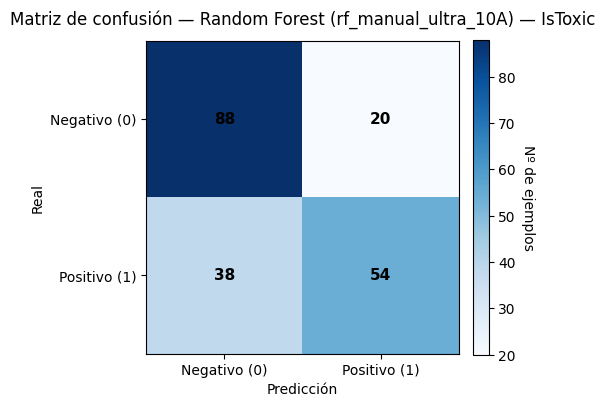


**📌 Detalle matriz de confusión — Random Forest (rf_manual_ultra_10A) — IsToxic**
- TN: **88**
- FP: **20**
- FN: **38**
- TP: **54**

En este proyecto es especialmente importante vigilar los **FN**,
porque representan mensajes tóxicos que el modelo no detecta.


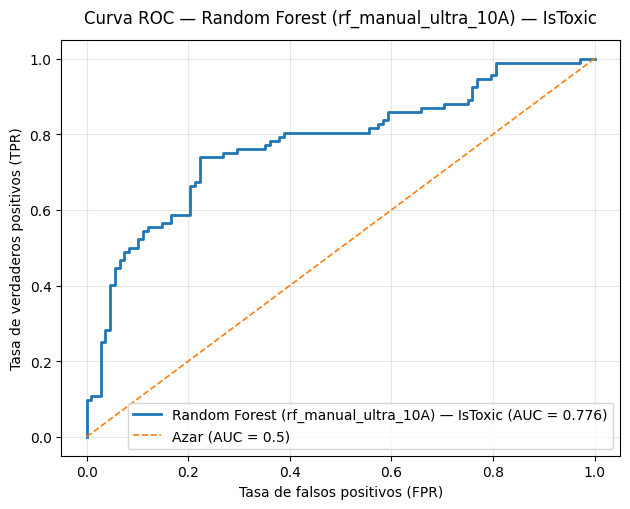


**📈 Curva ROC — Random Forest (rf_manual_ultra_10A) — IsToxic**

El modelo obtiene un **ROC-AUC = 0.776**.
Cuanto más se acerque la curva a la esquina superior izquierda,
mejor separa mensajes tóxicos de no tóxicos.


In [146]:
# === 11.1 Plots for best Random Forest candidate ============================

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

display(Markdown(" 📊 **Visualización del mejor modelo Random Forest**"))

# ---------------------------------------------------------------------------
# Safety aliases to avoid NameError across notebook versions
# ---------------------------------------------------------------------------
# English: We keep backward-compatible variable names so this cell
# works even if previous cells used slightly different naming.

if "best_model" not in globals():
    if "best_pipeline" in globals():
        best_model = best_pipeline
    else:
        raise ValueError("❌ No encuentro `best_model` ni `best_pipeline`. Ejecuta antes la celda 11.")

if "best_tag" not in globals():
    if "best_rf_name" in globals():
        best_tag = best_rf_name
    else:
        best_tag = "best_rf"

# ---------------------------------------------------------------------------
# Plot helper
# ---------------------------------------------------------------------------

def plot_confusion_and_roc(model, X_te, y_te, title_prefix="Modelo"):
    """Plot confusion matrix and ROC curve for a binary classifier."""

    # Predict labels
    y_pred = model.predict(X_te)

    # Predict probabilities if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = None

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # ---- Confusion matrix plot ----
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_title(f"Matriz de confusión — {title_prefix}", fontsize=12, pad=12)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Negativo (0)", "Positivo (1)"])
    ax.set_yticklabels(["Negativo (0)", "Positivo (1)"])

    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                fontsize=11, fontweight="bold"
            )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Nº de ejemplos", rotation=270, labelpad=14)

    plt.tight_layout()
    plt.show()

    display(Markdown(f"""
**📌 Detalle matriz de confusión — {title_prefix}**
- TN: **{tn}**
- FP: **{fp}**
- FN: **{fn}**
- TP: **{tp}**

En este proyecto es especialmente importante vigilar los **FN**,
porque representan mensajes tóxicos que el modelo no detecta.
"""))

    # ---- ROC curve plot ----
    if y_proba is not None:
        roc_auc = roc_auc_score(y_te, y_proba)
        fpr, tpr, _ = roc_curve(y_te, y_proba)

        plt.figure(figsize=(6.4, 5.2))
        plt.plot(fpr, tpr, linewidth=2, label=f"{title_prefix} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, label="Azar (AUC = 0.5)")

        plt.xlabel("Tasa de falsos positivos (FPR)")
        plt.ylabel("Tasa de verdaderos positivos (TPR)")
        plt.title(f"Curva ROC — {title_prefix}", fontsize=12, pad=12)
        plt.grid(alpha=0.3)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        display(Markdown(f"""
**📈 Curva ROC — {title_prefix}**

El modelo obtiene un **ROC-AUC = {roc_auc:.3f}**.
Cuanto más se acerque la curva a la esquina superior izquierda,
mejor separa mensajes tóxicos de no tóxicos.
"""))
    else:
        display(Markdown(
            "⚠️ Este modelo no expone `predict_proba`, así que no se puede dibujar la curva ROC."
        ))


# ---------------------------------------------------------------------------
# Use the best model selected in cell 11
# ---------------------------------------------------------------------------

plot_confusion_and_roc(
    best_model,
    X_test,
    y_test,
    title_prefix=f"Random Forest ({best_tag}) — {TARGET_COL}"
)


### 11.2 Comparación rápida de candidatos (baseline vs tuning + enfoques conservadores)

En esta celda:

- Construimos una tabla compacta y un gráfico simple con métricas clave de test
  y, cuando aporta valor, también con métricas de train para visualizar el gap:

  - **Baseline**
  - **GridSearchCV**
  - **GridSearchCV regularizado**
  - **Optuna**
  - **Optuna regularizado**
  - **Ajuste manual ultra-regularizado (10A)**
  - **Mejor candidato del barrido conservador (10B)**

- Mostramos principalmente:
  - **F1-score (train/test)**
  - **ROC-AUC (train/test)**
  - **Gap F1**

Esta comparación “rápida” sirve como apoyo visual para justificar la decisión final:

- Si un modelo mejora F1 en test pero mantiene un gap alto,
  lo consideramos menos fiable para este dataset.
- Si un modelo obtiene un F1_test competitivo con gap bajo,
  lo priorizamos como solución más estable para la rúbrica y el objetivo del proyecto.


 🧪 **Comparación rápida de candidatos Random Forest**

 📋 **Resumen compacto (train/test/gap)**

,model,F1_train,F1_test,gap_f1,ROC_train,ROC_test
6,rf_safe_C_10B,0.6526,0.6467,0.0059,0.7981,0.7305
5,rf_manual_ultra_10A,0.6667,0.6506,0.0161,0.8451,0.7758
2,rf_grid_regularized,0.7788,0.6871,0.0916,0.9178,0.8001
0,rf_baseline,0.7865,0.6463,0.1402,0.9143,0.7925
3,rf_optuna,0.7865,0.6463,0.1402,0.9143,0.7925
4,rf_optuna_regularized,0.7865,0.6463,0.1402,0.9143,0.7925
1,rf_grid,0.9296,0.7326,0.1970,0.9840,0.8142


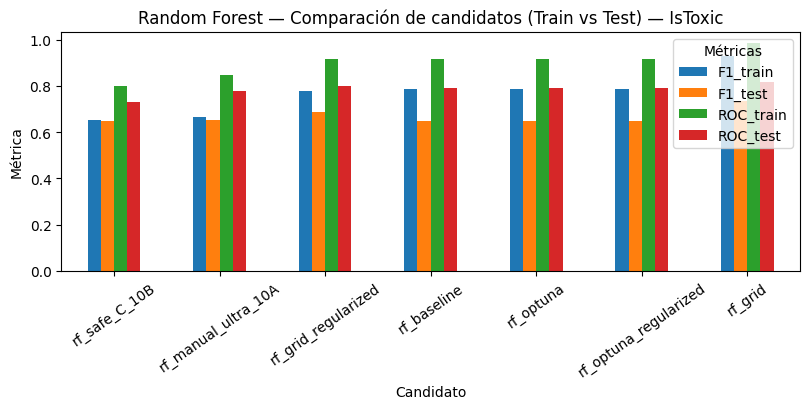


**🔎 Interpretación**

- Este resumen permite ver de un vistazo:
  - qué modelo rinde mejor en test,
  - y cuál mantiene un comportamiento más estable entre train y test.

- En datasets pequeños con TF-IDF:
  - los modelos muy optimizados pueden mejorar F1 en test,
    pero si el gap crece demasiado, no cumplen la rúbrica.

- Si aparecen varios candidatos con gap ≤ 0.05,
  priorizamos el de **mejor F1_test**.


In [147]:
# === 11.2 Quick candidate comparison ========================================

display(Markdown(" 🧪 **Comparación rápida de candidatos Random Forest**"))

# We reuse the final comparison dataframe from cell 11
if "df_rf_compare" not in globals() or df_rf_compare.empty:
    raise ValueError("❌ No existe `df_rf_compare`. Ejecuta antes la celda 11.")

# Small summary table
df_quick = df_rf_compare[["model", "F1_train", "F1_test", "gap_f1", "ROC_train", "ROC_test"]].copy()

display(Markdown(" 📋 **Resumen compacto (train/test/gap)**"))
display(df_quick.sort_values(by=["gap_f1", "F1_test"], ascending=[True, False]).round(4))

# Bar chart: F1 and ROC in train/test
plot_df = df_quick.set_index("model")[["F1_train", "F1_test", "ROC_train", "ROC_test"]]

fig, ax = plt.subplots(figsize=(8.2, 4.2))
plot_df.plot(kind="bar", ax=ax, rot=35)

ax.set_title(f"Random Forest — Comparación de candidatos (Train vs Test) — {TARGET_COL}")
ax.set_xlabel("Candidato")
ax.set_ylabel("Métrica")
ax.legend(title="Métricas")
plt.tight_layout()
plt.show()

display(Markdown("""
**🔎 Interpretación**

- Este resumen permite ver de un vistazo:
  - qué modelo rinde mejor en test,
  - y cuál mantiene un comportamiento más estable entre train y test.

- En datasets pequeños con TF-IDF:
  - los modelos muy optimizados pueden mejorar F1 en test,
    pero si el gap crece demasiado, no cumplen la rúbrica.

- Si aparecen varios candidatos con gap ≤ 0.05,
  priorizamos el de **mejor F1_test**.
"""))


### 12. Guardado del modelo y JSON final

En esta celda:

- Calculamos:
  - número de features de texto
  - número de features numéricas
- Construimos el JSON estándar.
- Guardamos:
  - `.pkl` del pipeline
  - `.json` de resultados

El nombre final del modelo quedará sin versiones.


In [149]:
# === 12. Save best model and JSON (with winner tag) =========================

import json
import re
import joblib
import pandas as pd
from datetime import datetime
from IPython.display import display, Markdown

display(Markdown("### 💾 Guardado del mejor modelo Random Forest y JSON final"))

# ---------------------------------------------------------------------------
# Safety aliases to avoid NameError across notebook versions
# ---------------------------------------------------------------------------
# English: Keep backward compatibility with earlier naming choices.

if "best_model" not in globals():
    if "best_pipeline" in globals():
        best_model = best_pipeline
    else:
        raise ValueError("❌ No encuentro `best_model` ni `best_pipeline`. Ejecuta antes la celda 11.")

if "best_rf_name" not in globals():
    best_rf_name = "best_rf"

if "best_test_metrics" not in globals() or "best_train_metrics" not in globals():
    # English: Recompute if metric dicts were not exposed by cell 11
    best_train_metrics, best_test_metrics, best_f1_gap = rf_evaluate_train_test(
        best_model, X_train, y_train, X_test, y_test
    )

if "best_f1_gap" not in globals():
    best_f1_gap = best_train_metrics["f1"] - best_test_metrics["f1"]

# ---------------------------------------------------------------------------
# 1) Build a short, readable suffix from the winning candidate name
# ---------------------------------------------------------------------------

# Map internal candidate names -> friendly suffix
suffix_map = {
    "rf_baseline": "baseline",
    "rf_grid": "grid",
    "rf_grid_regularized": "grid_reg",
    "rf_optuna": "optuna",
    "rf_optuna_regularized": "optuna_reg",
}

raw_suffix = str(best_rf_name)

# English: normalize conservative winners to clean business-friendly tags.
# We avoid exposing internal cell numbering like 10A/10B in filenames.
if "manual_ultra" in raw_suffix:
    raw_suffix = "manual_ultra"
elif raw_suffix.startswith("rf_safe_") or raw_suffix.endswith("_10B"):
    raw_suffix = "safe_best"
else:
    raw_suffix = suffix_map.get(raw_suffix, raw_suffix)

# Sanitize to avoid weird characters in filenames
safe_suffix = re.sub(r"[^a-zA-Z0-9_]+", "_", raw_suffix).strip("_").lower()

# Final model name with winner tag
model_name = f"random_forest_{TARGET_COL}_{safe_suffix}"

display(Markdown(f"""
**🏷️ Nombre final del modelo:**
- `{model_name}`

Esto permite identificar rápidamente al ganador solo viendo  
el `.json` o el `.pkl`.
"""))

# ---------------------------------------------------------------------------
# 2) Mini-tabla resumen final (train/test/gap) antes del guardado
# ---------------------------------------------------------------------------

display(Markdown("#### ✅ Resumen final del ganador (train/test/gap)"))

df_winner = pd.DataFrame([{
    "model": best_rf_name,
    "F1_train": best_train_metrics["f1"],
    "F1_test": best_test_metrics["f1"],
    "gap_f1": best_f1_gap,
    "ROC_train": best_train_metrics["roc_auc"],
    "ROC_test": best_test_metrics["roc_auc"],
}])

display(df_winner.round(4))

# ---------------------------------------------------------------------------
# 3) Feature counts (robust)
# ---------------------------------------------------------------------------

try:
    text_vectorizer = best_model.named_steps["features"].named_transformers_["text"]
    n_features_text = len(text_vectorizer.get_feature_names_out())
except Exception:
    n_features_text = 0

n_features_numeric = len(numeric_features)
n_samples = int(df.shape[0])

# ---------------------------------------------------------------------------
# 4) Build standard results dictionary
# ---------------------------------------------------------------------------

results_dict = {
    "model_name": model_name,
    "task": "binary_classification",
    "target_label": TARGET_COL,
    "data": {
        "n_samples": n_samples,
        "n_features_text": int(n_features_text),
        "n_features_numeric": int(n_features_numeric),
        "train_size": float(X_train.shape[0] / n_samples),
        "test_size": float(X_test.shape[0] / n_samples),
        "random_state": int(RANDOM_STATE),
    },
    "metrics": {
        "accuracy": float(best_test_metrics["accuracy"]),
        "precision": float(best_test_metrics["precision"]),
        "recall": float(best_test_metrics["recall"]),
        "f1": float(best_test_metrics["f1"]),
        "roc_auc": float(best_test_metrics["roc_auc"]),
    },
    "confusion_matrix": {
        "tn": int(best_test_metrics["tn"]),
        "fp": int(best_test_metrics["fp"]),
        "fn": int(best_test_metrics["fn"]),
        "tp": int(best_test_metrics["tp"]),
    },
    "overfitting_control": {
        "f1_gap_train_test": float(best_f1_gap),
        "rubric_threshold": 0.05,
        "rubric_compliant": bool(best_f1_gap <= 0.05),
    },
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "notes": (
        f"Random Forest winner: {best_rf_name}. "
        "TF-IDF (1,2) + 5 numeric features. "
        "Selection rule: prioritize gap ≤ 0.05, then maximize F1_test."
    ),
}

# ---------------------------------------------------------------------------
# 5) Save JSON and model
# ---------------------------------------------------------------------------

json_path = results_dir / f"{model_name}.json"
model_path = models_dir / f"{model_name}.pkl"

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

joblib.dump(best_model, model_path)

print("✅ Guardado completado")
print(f"🧠 Modelo (.pkl): {model_path}")
print(f"📄 Resultados JSON: {json_path}")

display(Markdown("""
✅ Este JSON sigue el esquema estándar del proyecto  
y es compatible con `comparison_models.ipynb`.
"""))


### 💾 Guardado del mejor modelo Random Forest y JSON final


**🏷️ Nombre final del modelo:**
- `random_forest_IsToxic_manual_ultra`

Esto permite identificar rápidamente al ganador solo viendo  
el `.json` o el `.pkl`.


#### ✅ Resumen final del ganador (train/test/gap)

,model,F1_train,F1_test,gap_f1,ROC_train,ROC_test
0,rf_manual_ultra_10A,0.6667,0.6506,0.0161,0.8451,0.7758


✅ Guardado completado
🧠 Modelo (.pkl): C:\dev\proyectos\PX_NLP_G4\backend\models\random_forest_IsToxic_manual_ultra.pkl
📄 Resultados JSON: C:\dev\proyectos\PX_NLP_G4\data\results\random_forest_IsToxic_manual_ultra.json



✅ Este JSON sigue el esquema estándar del proyecto  
y es compatible con `comparison_models.ipynb`.


### 13. Conclusiones — Random Forest (IsToxic)

En este notebook entrenamos y comparamos varias versiones de **Random Forest**
para detección de toxicidad usando:

- `text_classic` como texto preprocesado.
- TF-IDF con n-gramas (1,2).
- 5 variables numéricas del dataset limpio.

#### Hallazgos clave

1. **El baseline mostró overfitting**:  
   en datasets pequeños con TF-IDF de alta dimensionalidad,
   Random Forest puede memorizar patrones del entrenamiento.

2. **GridSearchCV y Optuna mejoraron F1**, pero:  
   el *gap* train–test siguió por encima del criterio de la rúbrica.

3. **El ajuste conservador fue decisivo**:  
   - **10A** (manual ultra-regularizado) logró un equilibrio estable con `gap_f1 ≤ 0.05`.  
   - **10B** confirmó que existían configuraciones similares, validando la estrategia.

4. **Selección final**:  
   priorizamos **generalización** frente a mejora puntual en test:  
   > `F1_train - F1_test ≤ 0.05`  
   y, entre los modelos que cumplían, elegimos el de **mejor F1_test**.

#### ¿Dónde está la parte de “ensembles”?

Random Forest **es un modelo ensemble por definición**:
combina múltiples árboles mediante **bagging** y votación agregada.

En este notebook:
- **GridSearch y Optuna no crean el ensemble**,  
  sino que **optimizan los hiperparámetros** del ensemble ya existente.

#### Resultado final

El modelo guardado (`.pkl`) y su JSON asociado quedan listos para:
- la API del proyecto,
- y la comparación global en `comparison_models.ipynb`.
